# GAN 3.0
Through my research, I was able to decided to use a GAN to create music. I would first convert .wav files to pngs and use that throughout my GAN. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

The import statement above is used for some prints and special uses from tensorflow beta 2.0. Below of the required import statements to run and use the GAN

In [2]:
import tensorflow as tf
import glob#finds pathnames
import imageio#handles image input and output
import matplotlib.pyplot as plt#data visulization
import numpy as np#obivous array and math uses
import os#helps uses files across different os
import PIL#pictures
import numpy
import math
from PIL import Image
from scipy.io.wavfile import read, write
from tensorflow.keras import layers#layers in the neural nets
import time#to figure out timings
from tqdm import tqdm
import image_slicer
from pathlib import Path
from IPython import display#will show the resulting converted pngs
BATCH_SIZE = 224
import scipy

/Users/viggy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/viggy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/viggy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/viggy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

# Inputting .wav files and Converting them

In [3]:
def crop(img):
    print("start cropping")
    images=[]
    #print(img)
    #image_obj = Image.open(image_path)
    #%pylab inline
    #import matplotlib.pyplot as plt
    #import matplotlib.image as mpimg
    #img=mpimg.imread('your_image.png')
    #imgplot = plt.imshow(img)
    #plt.show()
    imm=Image.open("vs1-1ada.png")
    current_x=0
    current_y=0
    next_x=28
    next_y=28
    coords=[current_x,current_y,next_x,next_y]
    count=30
    i=1
    pbar = tqdm(total=5)
    while i<30 and next_y < img.shape[1]:
        while next_x < im.shape[0]and i<=30:
            cropped_image = np.array(imm.crop(coords))
            #cropped_image.save(saved_location)
            images.append(cropped_image)
            coords=[current_x+28,current_y,next_x+28,next_y]
            i+=1
            pbar.update(30)
        current_x=0
        current_y=0
        next_x=0
        next_y=0
        coords=[current_x,current_y,next_x+28,next_y+28]
       
    
    pbar.close()
    #cropped_image.show()
    print("Done Cropping")
    return images

In [62]:

os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001")
# read the WAV data
wavs_in = []
png_data = []
song=0
print("out")

for filename in glob.glob("*.wav"):
    print(filename)
    print("work")
    wavs_in.append(read(filename))
    wav_data = list(wavs_in[song][1])
    #print(list(wavs_in[song]))
    png_data = []
    print("after png")
    for d in wav_data:
        # split all 16-bit integers in WAV file to 2x 8 bit integers;
        # 1 16 bit int per pixel
        d_1 = (((d[0] >> 8) & 0xff), d[0] & 0xff, 0)
        d_2 = (((d[1] >> 8) & 0xff), d[1] & 0xff, 0)
        png_data.append(d_1)
        png_data.append(d_2)
    print("append")
    # ending indicator pixel uses the green channel
    # (green channel set to 0 for all data pixels)
    png_data += [(255, 255, 255)]
    # find a roughly square size of output image
    n = len(png_data)
    x = math.floor(math.sqrt(n))
    y = x + math.ceil((n - x ** 2) / x)

    # output the PNG image
    img = PIL.Image.new('RGB', (int(x), int(y)), color = 'white')
    img.putdata(png_data)
    img.save(filename.replace(".wav",".png"))
    song+=1
print("fin")

out
out.wav
work
after png


KeyboardInterrupt: 

# Generator

In [52]:
def generator_model():

    model=tf.keras.Sequential()
    model.add(layers.Dense(14*14*256,use_bias=True,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((14,14,256)))
    assert model.output_shape==(None,14,14,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=True))
    assert model.output_shape==(None,14,14,128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=True))
    assert model.output_shape==(None,28,28,64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=True,activation='sigmoid'))
    assert model.output_shape==(None,56,56,3)
    
    return model

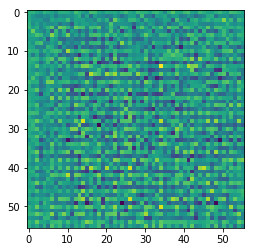

In [53]:
generator=generator_model()

noise=tf.random.normal([1, 100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0])

# Discriminator

In [54]:
def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[56,56,3]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    #model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [55]:
discriminator=discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor(
[[[[ 0.00148214]
   [-0.01773776]
   [-0.01724396]
   [-0.01722912]
   [-0.01770959]
   [-0.01767508]
   [-0.01718032]
   [-0.01743895]
   [-0.01737019]
   [-0.01741397]
   [-0.01771889]
   [-0.01724999]
   [-0.0183535 ]
   [ 0.04735195]]

  [[ 0.00405548]
   [-0.03310055]
   [-0.03310803]
   [-0.03340476]
   [-0.03348968]
   [-0.03277613]
   [-0.03336415]
   [-0.03290447]
   [-0.03322876]
   [-0.03327176]
   [-0.0333734 ]
   [-0.03372386]
   [-0.03454388]
   [ 0.04054902]]

  [[ 0.00414849]
   [-0.03306224]
   [-0.03309126]
   [-0.03334975]
   [-0.03321002]
   [-0.03353956]
   [-0.0332329 ]
   [-0.03305638]
   [-0.03360506]
   [-0.03333826]
   [-0.03367547]
   [-0.03348043]
   [-0.0345173 ]
   [ 0.04084981]]

  [[ 0.00431529]
   [-0.03269635]
   [-0.03283821]
   [-0.03307509]
   [-0.03348343]
   [-0.03396656]
   [-0.03328366]
   [-0.03388589]
   [-0.03367735]
   [-0.03384368]
   [-0.03379135]
   [-0.03313471]
   [-0.03471082]
   [ 0.0407447 ]]

  [[ 0.00390808]
   [-0.03317

# Adding Losses and Optimizers

In [56]:
#keras helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [57]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [58]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [60]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

# Training Epochs

In [61]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [62]:
@tf.function
def train_step(images):
    noise = tf.random.normal([30, noise_dim])
    print("in train_step")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [63]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch" )
    print(epochs)
    for batch in dataset:
        train_step(batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [64]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      #plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [65]:
def split(img,time):
    #os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-ada/")
    #os.mkdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/input_img")
    os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/ezsplit")
    every_second=image_slicer.slice(img, time)
    #print(split.shape)
    return every_second

In [66]:
def dataset_1():
    ala_path="/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/ezsplit"
    #os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-ada")
    png_data = []
    for filename in glob.glob("*.png"):
        png_data.append(np.array(Image.open(ala_path+"/"+filename)))
    dataset1=np.array(png_data)
    return dataset1

# Training the model

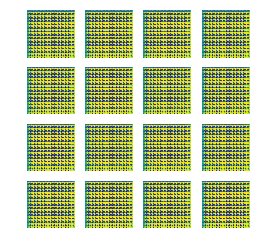

In [67]:

from scipy import ndimage, misc
filepath="/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-1ada.png"
#data=plt.imread(filepath)
#data.shape
#mage_resized = misc.imresize(image, (64, 64))
#data = data.reshape(28, 28, 1).astype('float32')
#data = (data - 127.5) / 127.5 # Normalize the images to [-1, 1]
images = []

ala_path="/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-ada"
print("reshaped")
#images.append(image_resized)
#%%time
im = plt.imread(filepath)
print(im.shape)
#uploaded=tf.image.decode_png(Image.open(filepath))
#crop(im)
#import cv2
#colors=[]
#colors=cv2.split(im)
#split(("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-1ada.png"),4)

#print(every_second)
#uploaded = every_second.resize(every_second.shape[0], 28, 28, 3).astype('float32')

#dataset1=dataset_1()
#dataset1=np.array(dataset1)
#print(dataset1[0].shape)
#print(dataset1)
#os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/final")
if os.path.exists("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001") :
    # Change the current working Directory    
    os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001")
else:
    print("Can't change the Current Working Directory")   
uploaded=crop(np.array(Image.open("vs1-1ada.png")))
up=np.array(uploaded)
up = up.reshape(up.shape[0], 28, 28, 3).astype('float32')
#up = (up - 127.5) / 127.5 # Normalize the images to [-1, 1]
up = np.expand_dims(up, axis=1)
train(up, EPOCHS)

In [68]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

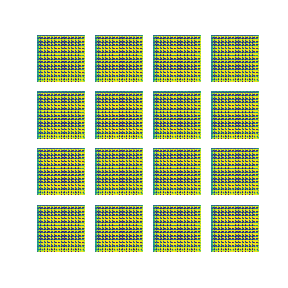

In [69]:
display_image(EPOCHS)

In [70]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [71]:
import numpy
import math
from PIL import Image
from scipy.io.wavfile import read, write
import os

print(os.getcwd())
#chdir
# read in the PNG file
img = Image.open("image_at_epoch_0020.png")

# look for the end indicator pixel and trim accordingly
png_data = list(img.getdata())
for i in range(len(png_data)):
    if png_data[i] == [255, 255, 255]: # look for end pixel
        png_data = png_data[:i]
        break

# convert data into WAV format
wav_data = []
for i in range(0, len(png_data), 2):
    # read the first integer from 2x 8 bit integers in the first pixel,
    # and the second from 2x 8 bit integers in the second pixel
    wav_data.append([(png_data[i][0] << 8) + png_data[i][1], 
                     (png_data[i+1][0] << 8) + png_data[i+1][1]]) 

# output the WAV audio
write('output56.wav', 44100, numpy.asarray(wav_data, dtype=numpy.int16))

/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001
